## Семинар 9: "LSTM"

ФИО:Вахрушев Вадим Юрьевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden = None):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        if hidden is None:
            hidden = (torch.zeros(1, 1, 
                                   self.hidden_size, requires_grad=True),
                      torch.zeros(1, 1, 
                                   self.hidden_size, requires_grad=True))           
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = torch.Tensor(seq_length, bs, self.hidden_size)
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

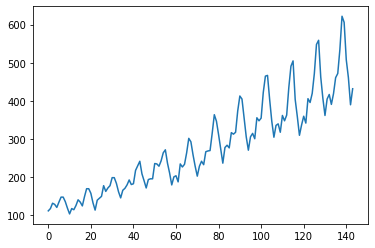

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [7]:
# Пример подготовленных данных

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [9]:
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [10]:
loss = nn.MSELoss()


In [40]:
def train_fun(model, look_back=1, n_epoch = 500):
    optimizer = optim.Adam(model.parameters())
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX =  torch.FloatTensor(trainX).view(trainX.shape[0], 1, trainX.shape[1])
    testX = torch.FloatTensor(testX).view(testX.shape[0], 1, testX.shape[1])
    epoch_losses = []
    for epoch in range(n_epoch):
        losses = []
        for i in range(len(trainY)):
            Y = torch.FloatTensor(trainY[i:i+1])
            if not i:
                y_pred, hid  = model( trainX[i:i+1])
            else:
                y_pred, hid  = model( trainX[i:i+1], hid)
            if len(hid) > 1:
                hid[0].detach_()
                hid[1].detach_()
            else:
                hid.detach_()
            cur_loss = loss(y_pred.mean(), Y)
            losses.append(np.array(cur_loss.data))
            optimizer.zero_grad()
            cur_loss.backward()
            optimizer.step()
        epoch_losses.append(np.mean(losses))
    predictions = []
    pred_no_teacher = []
    for i in range(len(testY)):
        if not i:
            y_pred, hid  = model( testX[i:i+1])
        else:
            y_pred, hid  = model( testX[i:i+1], hid)
        predictions.append(np.array(y_pred.data).mean())
    arr = testX[0:1]
    for i in range(len(testY)):
        if not i:
            y_pred, hid  = model(arr)
        else:
            y_pred, hid  = model(arr, hid)
        arr = np.append(np.asarray(np.array(arr.data).squeeze()),np.array(y_pred.data).mean())
        arr = arr[1:]
        arr = torch.unsqueeze(torch.FloatTensor(arr),0)
        arr = arr.view(arr.shape[0],1,arr.shape[1])
        pred_no_teacher.append(np.array(y_pred.data).mean())
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    plt.plot(epoch_losses)
    plt.title("Loss")
    ax2 = fig.add_subplot(132)
    plt.plot(np.array(predictions).reshape(-1), color = 'r')
    plt.plot(testY)
    plt.title("Prediction and reality")
    ax3 = fig.add_subplot(133)
    plt.plot(np.array(pred_no_teacher).reshape(-1), color = 'r')
    plt.plot(testY)
    plt.title("No teacher forcing prediction")
    plt.show()



попробуем разные размеры hidden слоя

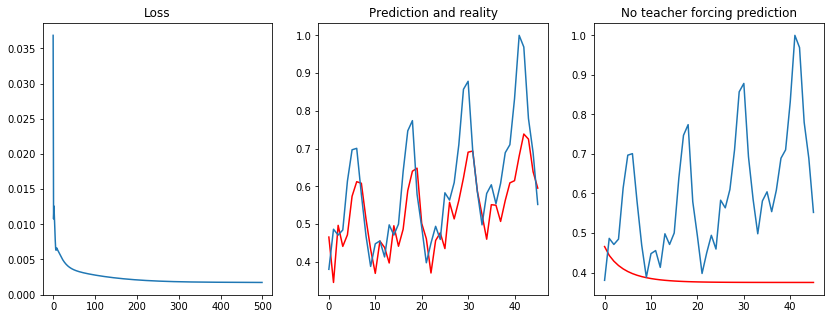

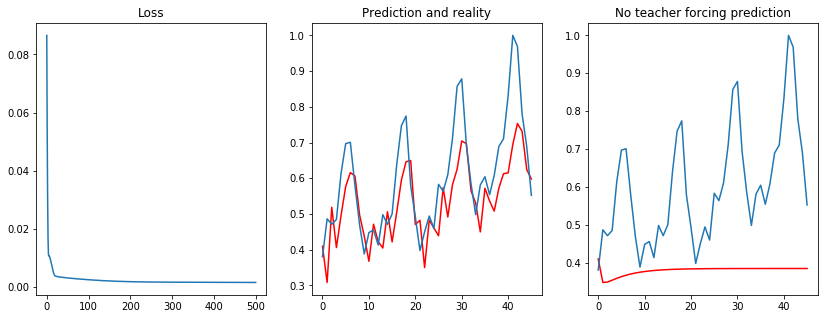

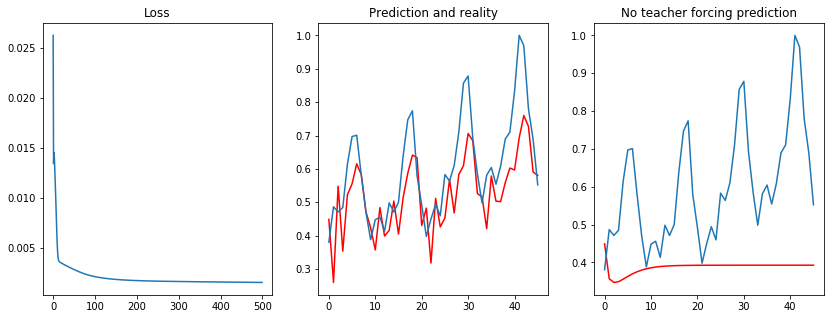

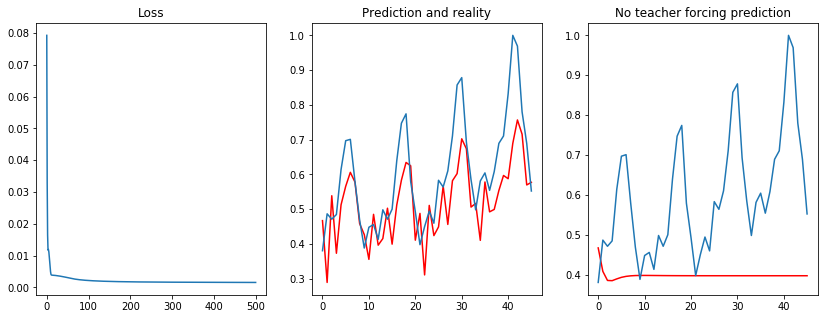

In [45]:


for i in range(1, 5):
    torch_lstm = nn.LSTM(input_size=1, hidden_size=i, num_layers=1)
    train_fun(torch_lstm)



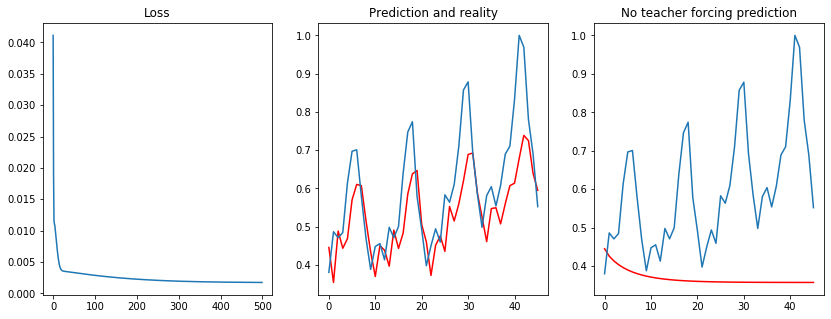

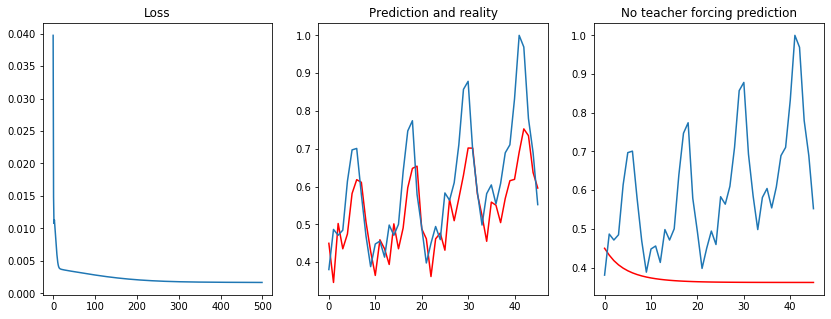

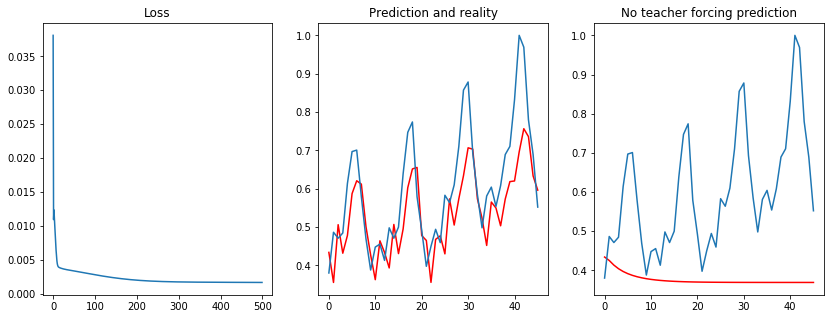

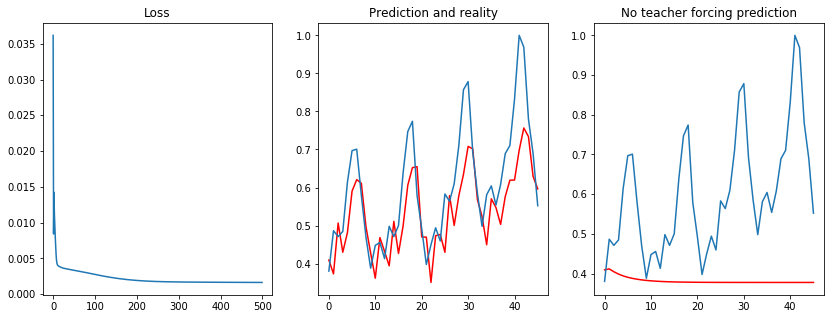

In [46]:
for i in range(1, 5):
    lstm = LSTM(input_size=1, hidden_size=i)
    train_fun(lstm)

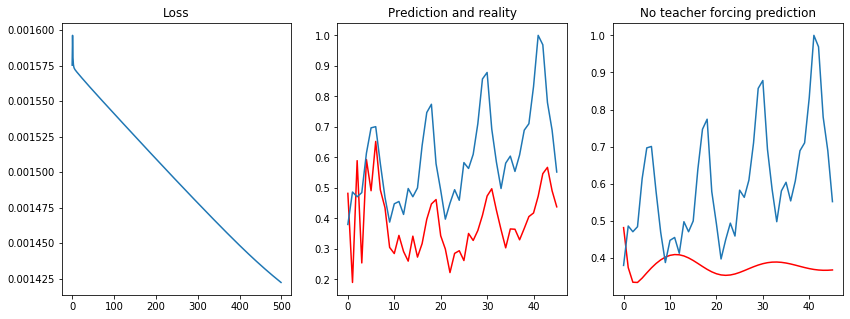

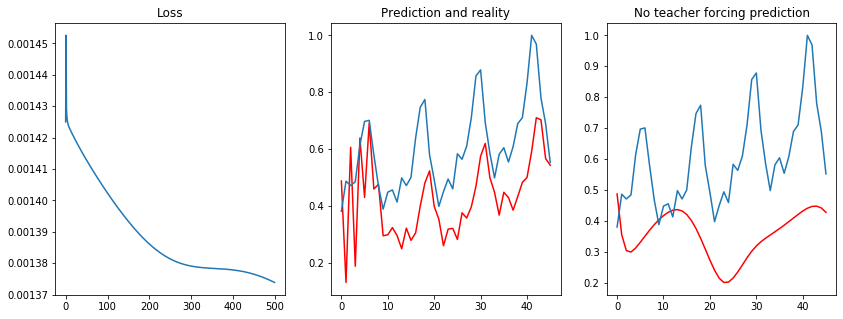

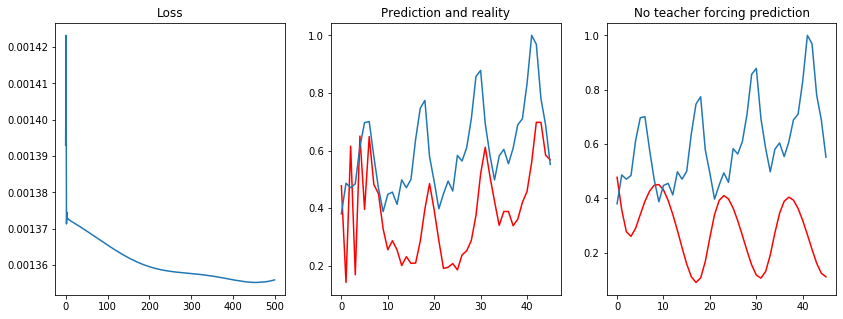

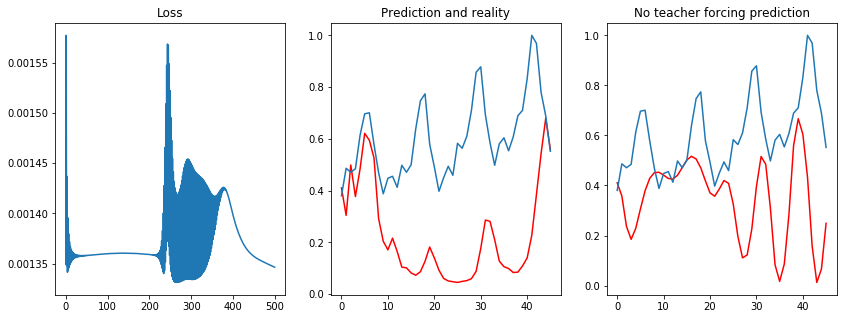

In [47]:
for i in range(1, 5):
    gru = nn.GRU(input_size=1, hidden_size=i, num_layers=1)
    train_fun(torch_lstm)

попробуем разные значения look_back

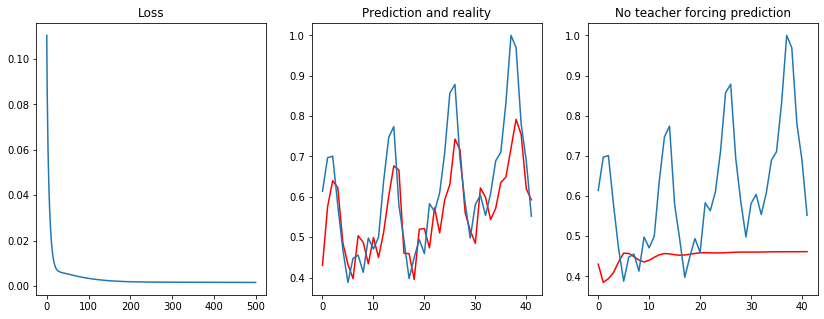

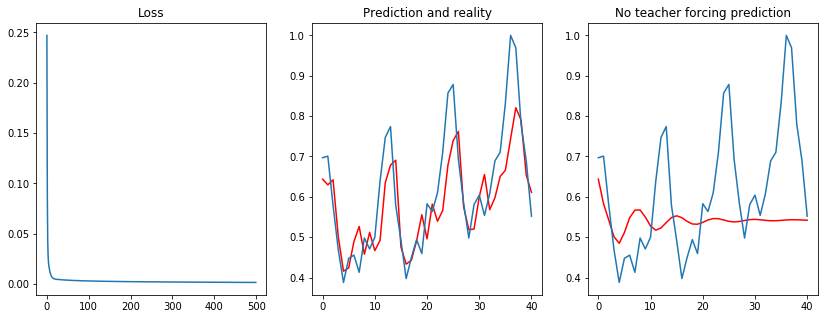

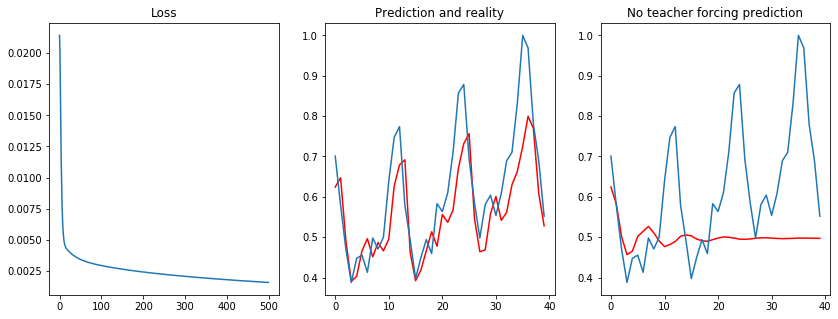

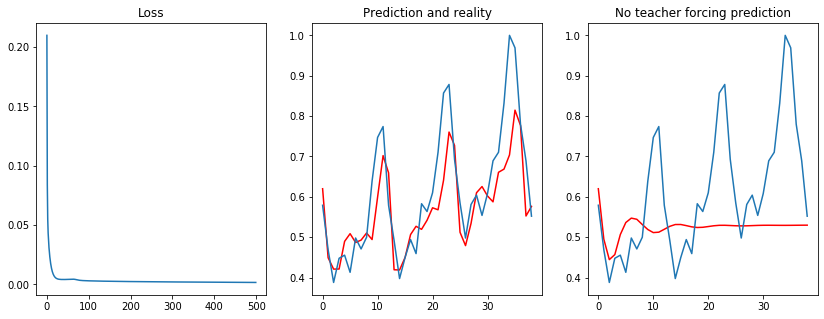

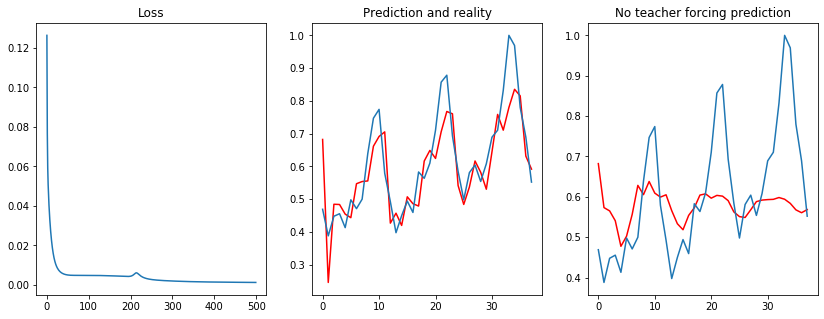

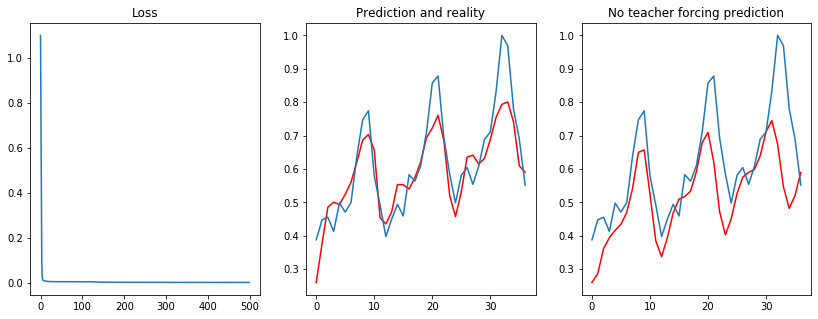

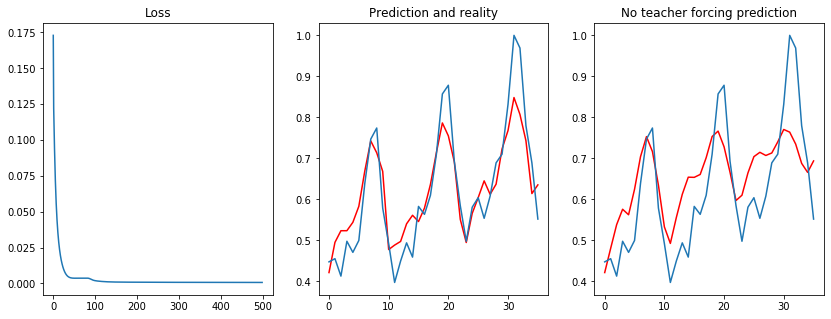

In [42]:
for i in range(5, 12):
    gru = nn.GRU(input_size=i, hidden_size=1, num_layers=1,batch_first = True)
    train_fun(gru, look_back=i )

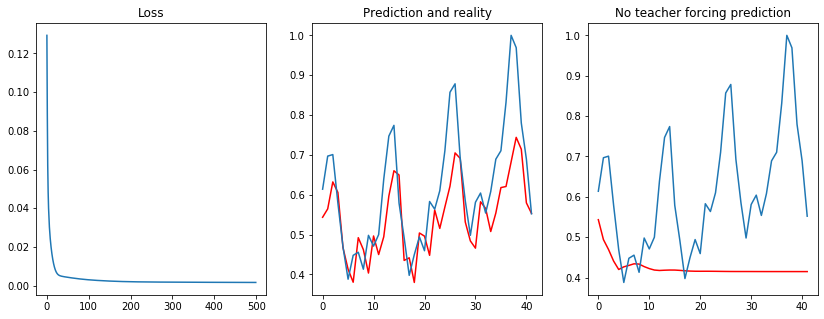

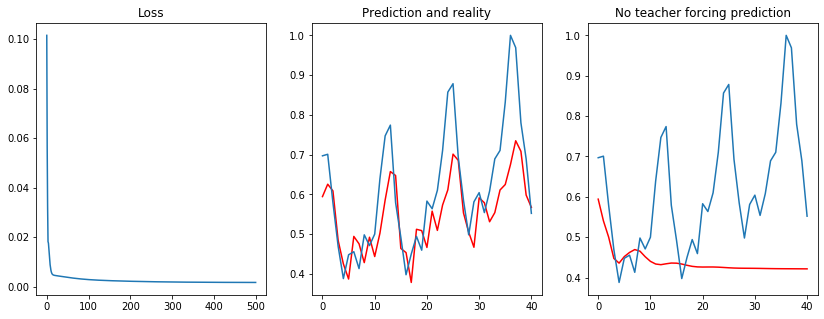

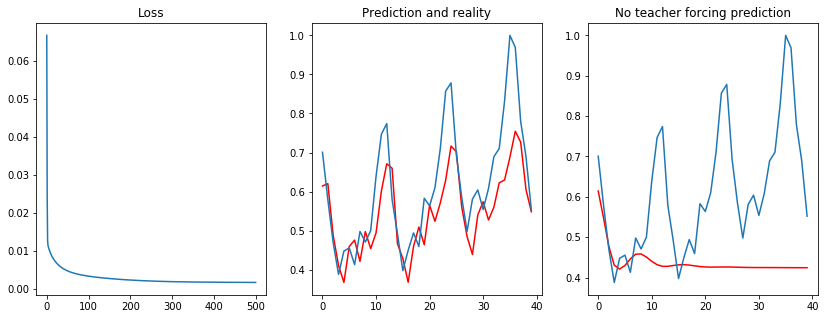

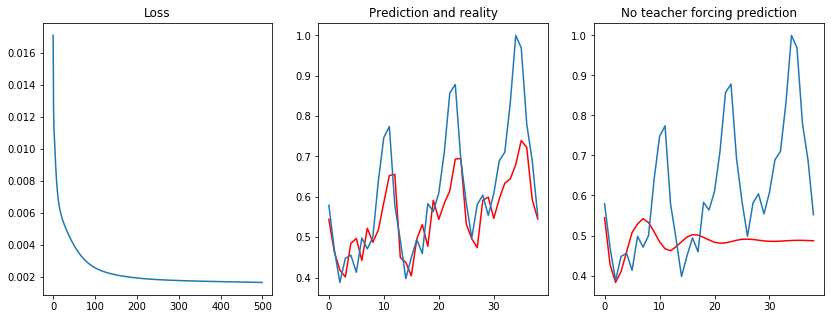

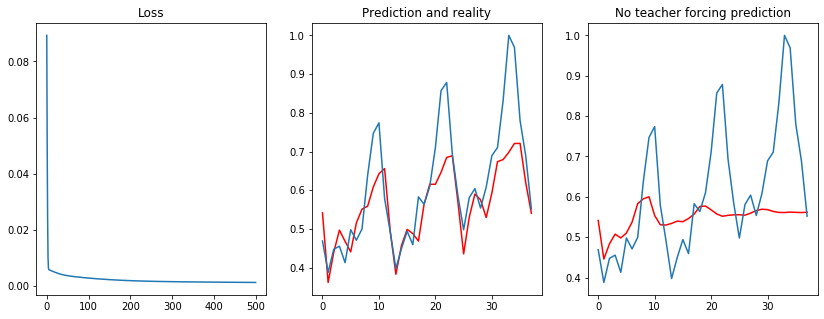

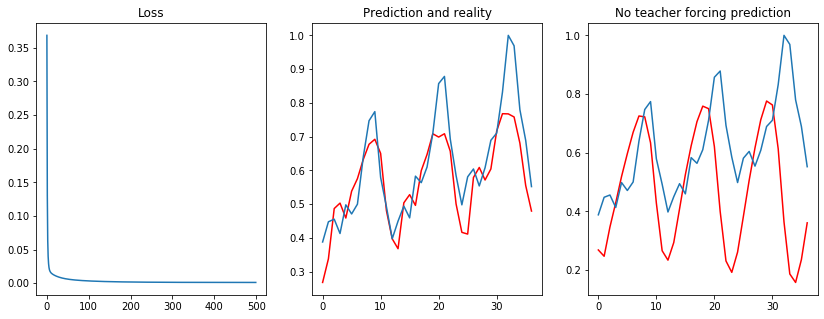

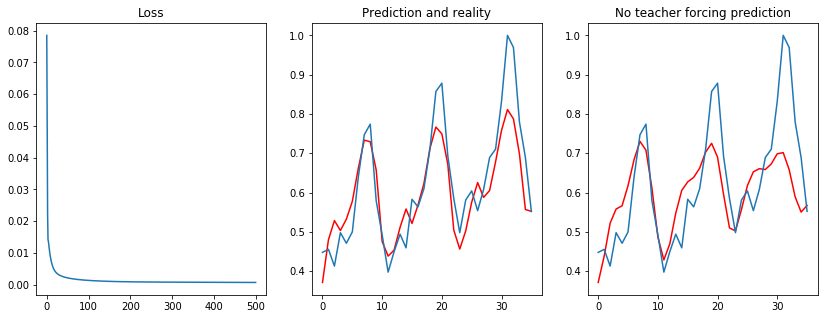

In [38]:
for i in range(5, 12):
    torch_lstm = nn.LSTM(input_size=i, hidden_size=1, num_layers=1)
    train_fun(torch_lstm, look_back=i )

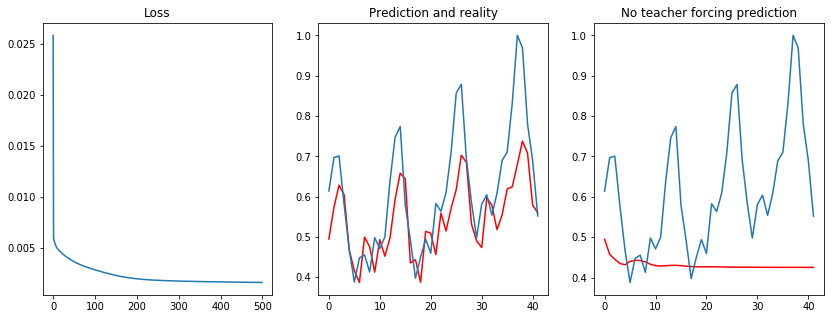

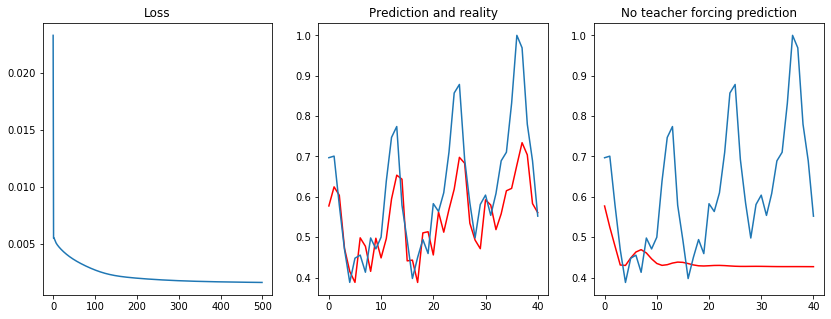

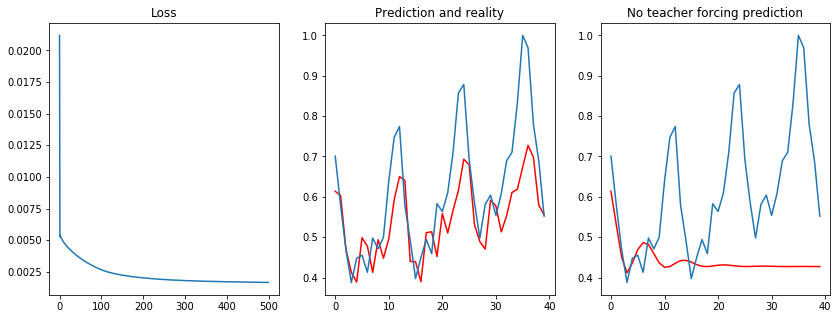

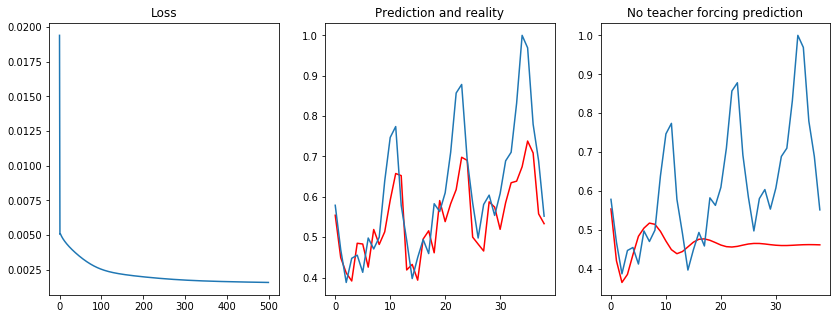

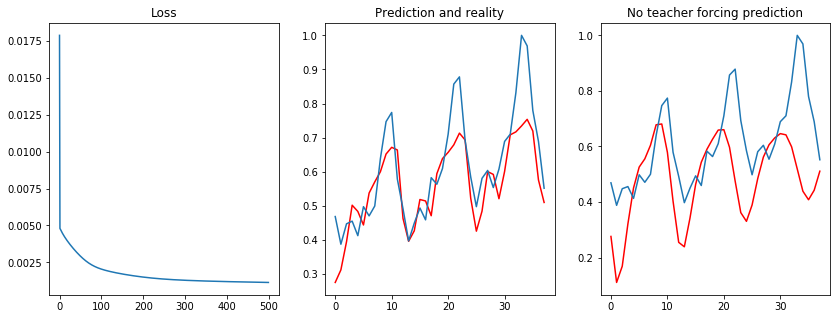

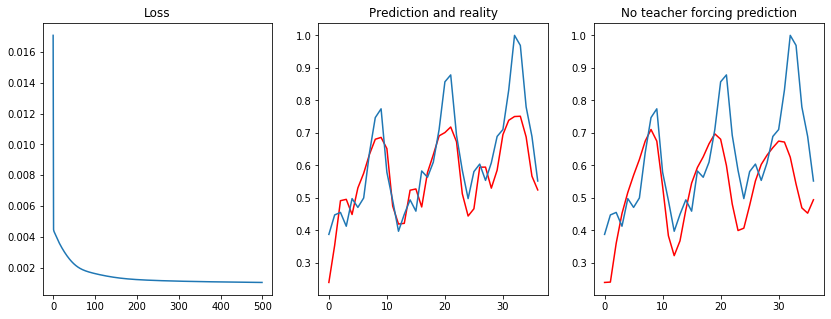

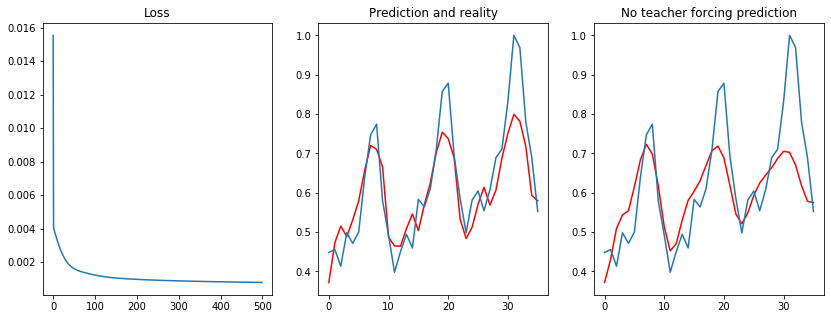

In [39]:
for i in range(5, 12):
    lstm = LSTM(input_size=i, hidden_size=1)
    train_fun(lstm, look_back=i )

можно сделать вывод, что GRU показал худшие результаты при увеличении размеров выходного эмбеддинга. Однако, он имеет наименьший лосс, поэтому дело, скорее всего, в переобучении. Также без использования teacher forcing результаты всех моделей улучшаются с увеличением look_back. Это логично, так как чем больше прошлых значений подается на вход, тем проще предсказать будущее

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: